<a href="https://colab.research.google.com/github/Gustave-MB/water_extent_extraction/blob/main/Water_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install PyCRS geedim

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 12.2 MB/s eta 0:00:00
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=2d9ffc3cc5f24735ccee0027a9d17f78aa8a7885685a88ec9ef85690190bcb9f
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built PyCRS


In [2]:
# Setup
import ee
import geemap
import geopandas as gpd
import fiona

import rasterio
from rasterio.features import rasterize
from shapely.geometry import shape, mapping
from pyproj import Transformer
from fiona.transform import transform_geom
import numpy as np

In [3]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-mbwirayesugustave')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


## Shapefiles

In [5]:
gdf = gpd.read_file("/content/gdrive/MyDrive/Flood_Forecasting/data/Waterbodies/Aquatic_Border_Clip.shp"
)
gdf

,objectid_1,objectid,type,name,source,captured,shape_leng,globalid,created_us,created_da,last_edite,last_edi_1,shape_Le_1,shape_Area,geometry
0,1,1,Marsh,None,Orthophotos 2008/09,2009/10,3499.622818,{8C7FB9A4-9FF2-4C3D-A564-B1330C31DD1C},None,None,None,None,0.031568,0.000012,"POLYGON ((29.35356 -2.63666, 29.35376 -2.63668..."
1,2,2,Marsh,None,Orthophotos 2008/09,2009/10,8581.885907,{915EFBAB-DDDA-466A-BAD7-0854229747D8},None,None,None,None,0.077345,0.000030,"POLYGON ((29.33210 -2.58736, 29.33242 -2.58769..."
2,3,3,Marsh,None,Orthophotos 2008/09,2009/10,4071.139495,{6DE0EFFC-F3C0-4274-BC78-31594B91BF93},None,None,None,None,0.036664,0.000015,"POLYGON ((29.35102 -2.60010, 29.35120 -2.60046..."
3,4,4,Dam,None,Mapping on Google i*,2019,5138.266842,{B1CAE6AB-B263-43A3-8258-EB17CF482B6C},None,None,None,None,0.046355,0.000033,"POLYGON ((29.79453 -2.74241, 29.79455 -2.74249..."
4,5,5,Marsh,Ntosho,Orthophotos 2008/09,2009/10,1746.765947,{54242A60-2132-4F94-88B9-36EC647E929C},None,None,None,None,0.015774,0.000010,"POLYGON ((29.52640 -1.64632, 29.52525 -1.64807..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,353,0,Large river,Nyabarongo,Mapping on Google i*,2019,7941.982561,{BFDF46D9-74F6-487D-9B2E-1C27290F85BC},None,None,None,None,0.071599,0.000036,"POLYGON ((29.62462 -2.08663, 29.62442 -2.08696..."
353,354,0,Large river,Nyabarongo,Mapping on Google i*,2019,6108.067709,{05063DA3-B4B7-4995-8DCA-9971AECCA7E4},None,None,None,None,0.055084,0.000026,"POLYGON ((29.63709 -2.07542, 29.63712 -2.07600..."
354,355,0,Large river,Nyabarongo,Mapping on Google i*,2019,9126.539459,{85D19F95-3F30-49EC-879F-796E7E95AC6E},None,None,None,None,0.082304,0.000058,"POLYGON ((29.63966 -2.05703, 29.63976 -2.05736..."
355,356,0,Large river,Nyabarongo,Mapping on Google i*,2019,8501.287859,{144120FB-AEF9-4A06-9CE8-C070D33C960A},None,None,None,None,0.076603,0.000007,"POLYGON ((29.63790 -1.97741, 29.63781 -1.97752..."


In [6]:
# # Nyabarongo
# filtered_gdf = gdf[gdf['name'].isin(['Nyabarongo'])]

# # Save the filtered GeoDataFrame to a new shapefile
# filtered_gdf.to_file('/content/gdrive/MyDrive/Africa_GeoData_Modeling_Lab/Flood-Mapping/data/Nyabarongo/shapefiles/Multipolygon/Nyabarongo.shp')
# filtered_gdf

In [7]:
# import geopandas as gpd
# from shapely.ops import cascaded_union

# # Load the shapefile
# gdf = gpd.read_file('/content/gdrive/MyDrive/Africa_GeoData_Modeling_Lab/Flood-Mapping/data/Nyabarongo/shapefiles/Multipolygon/Nyabarongo.shp')

# # Combine all geometries into a single geometry
# combined_geometry = cascaded_union(gdf.geometry)

# # Create a new GeoDataFrame with the combined geometry
# boundary_gdf = gpd.GeoDataFrame(geometry=[combined_geometry], crs=gdf.crs)

# # Save the outer boundary to a new shapefile
# boundary_gdf.to_file('/content/gdrive/MyDrive/Africa_GeoData_Modeling_Lab/Flood-Mapping/data/Nyabarongo/shapefiles/Singlepolygon/Nyabarongo.shp')


In [8]:
shapefile_path = '/content/gdrive/MyDrive/Africa_GeoData_Modeling_Lab/Flood-Mapping/data/Nyabarongo/shapefiles/Singlepolygon/Nyabarongo.shp' # '/content/gdrive/MyDrive/Flood_Forecasting/data/marsh/marsh_rw.shp'

In [24]:
# #Defining study area by roi bounding box
# with fiona.open(shapefile_path, "r") as shapefile:
#         shapes = [shape(feature["geometry"]) for feature in shapefile]

#         # Calculate the bounding box of the shapefile
#         bounds = shapefile.bounds
#         output_bounds = [bounds[0], bounds[1], bounds[2], bounds[3]]
# roi = ee.Geometry.Rectangle(output_bounds)

In [10]:
import os
from shapely.ops import unary_union
import json

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Create a buffer around Nyabarongo city
gdf.geometry.iloc[0] = gdf.geometry.iloc[0].buffer(0.03)  # 0.02 degrees is approximately 2000 meters

# Convert the buffered GeoDataFrame to GeoJSON format
geojson = json.loads(gdf.to_json())

# Extract the geometry coordinates from the GeoJSON
coordinates = geojson['features'][0]['geometry']['coordinates']

# Create an Earth Engine polygon from the coordinates
roi = ee.Geometry.Polygon(coordinates)

In [33]:
#Define study time period
start_date =  '2023-04-01' # '2023-05-02' #
end_date = '2023-04-15' # '2023-05-13' #

## SAR Images

In [12]:
def mask_edge(image):
  edge = image.lt(-30.0)
  masked_image = image.mask().And(edge.Not())
  return image.updateMask(masked_image)


In [13]:
def calculate_water_index(image):
    # water index calculation: VH / VV
    water_index = image.select('VH').divide(image.select('VV')).rename('Water_Index')
    return image.addBands(water_index)

In [20]:
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get("histogram"))
    means = ee.Array(ee.Dictionary(histogram).get("bucketMeans"))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    # Compute between sum of squares, where each mean partitions the data.

    def func_xxx(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = (
            aMeans.multiply(aCounts)
            .reduce(ee.Reducer.sum(), [0])
            .get([0])
            .divide(aCount)
        )
        bCount = total.subtract(aCount)
        bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
            bCount.multiply(bMean.subtract(mean).pow(2))
        )

    bss = indices.map(func_xxx)

    # Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])


In [49]:
def extract_water_vv(image):
    histogram = image.select("VV").reduceRegion(
        **{
            "reducer": ee.Reducer.histogram(255, 2),
            "geometry": roi,
            "scale": 10,
            "bestEffort": True,
        }
    )
    threshold = otsu(histogram.get("VV"))
    threshold = -14  # Fixed threshold for water classification in dB
    water = image.select("VV").lt(threshold).rename('waterMask').selfMask()
    return image.addBands(water.set({"threshold": threshold}))

In [50]:
# Import Sentinel-1 and filter data series
sentinel1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
      .filterBounds(roi)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.contains(leftField=".geo", rightValue=roi))
      .map(lambda image: image.clip(roi))
      .map(mask_edge)
      )

In [51]:
classified = sentinel1.map(extract_water_vv)

In [52]:
classified

In [53]:
m = geemap.Map()
m.centerObject(roi, 12)

index_vis_params = {
    'bands': ['Water_Index'],
    # 'min': 0,
    # 'max': 1,
    'palette':  ['orange', 'yellow', 'lightblue',  'darkblue']  # Black to Blue
}

water_vis_params = {
    'bands': ['waterMask'],
    'min': 0,
    'max': 1,
    'palette': ['000000', '00FFFF']  # Black to Blue
}

# Add the layers to the map
m.addLayer(classified.median(), {'min': -25, 'max': 5}, 'Backscatter')
m.addLayer(classified.median(), water_vis_params, 'Sentinel1 Water')

In [54]:
m

Map(center=[-2.0169196044189577, 29.969241335000085], controls=(WidgetControl(options=['position', 'transparen…

## Optical Images

In [289]:
# Function to get and rename bands of interest from OLI.
def renameOli(img):
  return(img.select(
      ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
      ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL']))

# Function to get and rename bands of interest from ETM+.
def renameEtm(img):
  return(img.select(
      ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
      ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL']))
# Function to get and rename bands of interest from ETM+.
def renames2(img):
  return(img.select(
      ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'QA60'],
      ['Aerosols', 'Blue', 'Green', 'Red', 'Red Edge 1', 'Red Edge 2', 'Red Edge 3','NIR', 'Red Edge 4', 'water vapor', 'SWIR1', 'SWIR2', 'QA60']))


In [290]:
def importSentinel(start_date, end_date, roi):

    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        )

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(roi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


In [291]:
def maskCloudLandsat(image):
    # Bits 3 and 4 are cloud and cloud shadow, respectively.
    cloudsBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    qa = image.select('QA_PIXEL')

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
        .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

    # Return the masked image, scaled to reflectance, without the QA bands.
    return image.updateMask(mask)\
        .copyProperties(image, ['system:time_start'])

def mask_s2_clouds(image):
    cld_prb = ee.Image(image.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(80).rename('clouds').Not()

    # Add the cloud probability layer and cloud mask as image bands.
    return image.updateMask(is_cloud)

In [292]:
def calc_AWEInsh(img): # Automatic Water Extraction Index (AWEInsh)
    AWEInsh = img.expression('(4*(Green - SWIR1)-(0.25*NIR + 2.75*SWIR2))/10000',
        {
            'Green': img.select('Green'),
            'NIR': img.select('NIR'),
            'SWIR1': img.select('SWIR1'),
            'SWIR2': img.select('SWIR2'),
        }
    ).select([0], ['AWEI'])
    return img.addBands(AWEInsh)


In [293]:
# Function to add AWEI as a band
def calc_awei(img): # Automatic Water Extraction Index (AWEIsh)
  awei = img.expression('(Blue + 2.5*Green - 1.5*(NIR+SWIR1) - 0.25*SWIR2)/10000',
        {
          'Blue': img.select('Blue'),
          'Green': img.select('Green'),
          'NIR': img.select('NIR'),
          'SWIR1': img.select('SWIR1'),
          'SWIR2': img.select('SWIR2'),
        }).select([0], ['AWEI'])
  return img.addBands(awei)

In [294]:

def calc_swm(img): # Sentinel Water Mask  https://eoscience.esa.int/landtraining2017/files/posters/MILCZAREK.pdf
  swm = img.expression('((Blue + Green) / (NIR+SWIR1))', # ranges 0-12
        {
          'Blue': img.select('Blue'),
          'Green': img.select('Green'),
          'NIR': img.select('NIR'),
          'SWIR1': img.select('SWIR1'),
        }).select([0], ['SWM'])
  return img.addBands(swm)

In [295]:
def calc_EWI(img): # Enhenced Water Index (EWI)
  ewi = img.expression('(Green − NIR − SWIR1)/(Green + NIR + SWIR1)',
                        {
            'Green': img.select('Green'),
            'NIR': img.select('NIR'),
            'SWIR1': img.select('SWIR1'),
        }).select([0], ['EWI'])
  return img.addBands(ewi)

In [296]:
def add_waterMask(image):
    threshold = -14  # Fixed threshold for water classification in dB
    waterMask = image.select('VV').lt(threshold).rename('waterMask')
    waterMask = waterMask.updateMask(waterMask)
    return image.addBands(waterMask)

#Classify water vs non-water
def classify_waterAWEI(img):
    img = calc_awei(img)
    water_mask = img.select('AWEI').gt(0).rename('water_AWEI')
    water_mask = water_mask.updateMask(water_mask)
    return img.addBands(water_mask)


def classify_waterAWEInsh(img):
    img = calc_AWEInsh(img)
    water_mask = img.select('AWEI').gt(-0.3).rename('water_AWEI')  # -0.4 threshold good for dry season and long time series mosaics and -0.3 for rain season
    water_mask = water_mask.updateMask(water_mask)
    return img.addBands(water_mask)


def classify_waterSWM(img):
    img = calc_swm(img) # Threshold 1.4-1.6
    water_mask = img.select('SWM').gt(1.12).rename('water_SWM')
    water_mask = water_mask.updateMask(water_mask)
    return img.addBands(water_mask)

In [ ]:

# #Import Landsat Imagery from Collection 2, Rename and Scope Time Period
# L9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(roi).filterDate(start_date, end_date).map(renameOli)
# L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(roi).filterDate(start_date, end_date).map(renameOli)
# L7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(roi).filterDate(start_date, end_date).map(renameEtm)

# #Merge collections
# landsatcol = L7.merge(L8).merge(L9).sort('system:time_start')

# #Apply Cloud Mask functions to image collection
# landsatcol = landsatcol.map(maskCloudLandsat)

In [297]:
# Import Sentinel 2
S2col = importSentinel(start_date, end_date, roi)

In [298]:
# Rename Sentinel 2 bands and mask clouds
Sentinel2col = S2col.filterDate(start_date, end_date).map(renames2)#.map(mask_s2_clouds)

In [299]:
# Apply water classification to the image collection
# classified_landsatcol = landsatcol.map(classify_waterAWEI).map(lambda image: image.clip(roi))

classified_Sentinel2col = Sentinel2col.map(classify_waterAWEInsh).map(lambda image: image.clip(roi))

In [ ]:
# Map = geemap.Map()
# Map.centerObject(roi,12)

In [310]:
# Use median of Awei to visualize
# classified_landsatcol_median = classified_landsatcol.median()
classified_Sentinel2col_median = classified_Sentinel2col.median()

# Define visualization parameters using RGB bands and AWEI
rgb_vis_params = {
    'bands': ['Red', 'Green', 'Blue'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

water_vis_params_AWEI = {
    'bands': ['classification_AWEI'],
    'min': 0,
    'max': 1,
    'palette': ['000000', '00FFFF']  # Black to Blue
}

# Add the layers to the map
m.addLayer(classified_Sentinel2col_median, rgb_vis_params, 'RGB')
m.addLayer(classified_Sentinel2col_median, water_vis_params_AWEI, 'Sentinel2 Water')

m.add_shapefile(shapefile_path, layer_name='Water bodies')

In [311]:
# Display the map
m

Map(bottom=529782.0, center=[-1.7829305697787245, 29.798319766346935], controls=(WidgetControl(options=['posit…

In [ ]:
# Map.to_html(filename='/content/gdrive/MyDrive/Flood_Forecasting/Map_02_to_09_05_2023.html', title="Water Indices", width="100%", height="880px")

In [ ]:
# # Save image
# geemap.ee_export_image_to_drive(
#     classified_Sentinel2col_median.select(['classification_AWEI']), description="sentinel", folder="Flood_Forecasting", region=roi.geometry(), scale=10
# )

In [ ]:
# fishnet = geemap.fishnet(roi.geometry(), rows=10, cols=12, delta=0.5)

# # Too large file
# out_dir = '/content/gdrive/MyDrive/Flood_Forecasting/saved'
# geemap.download_ee_image_tiles(
#     classified_Sentinel2col_median.select(['classification_AWEI']), fishnet, out_dir, prefix="RW_", crs="EPSG:3857", scale=10
# )

In [ ]:
# !gdal_merge.py -o merged_image.tif RW_01.tif RW_02.tif RW_03.tif RW_04.tif RW_05.tif RW_06.tif RW_07.tif RW_08.tif RW_09.tif RW_10.tif RW_11.tif RW_12.tif RW_13.tif RW_14.tif RW_15.tif RW_16.tif RW_17.tif RW_1


## Evaluation

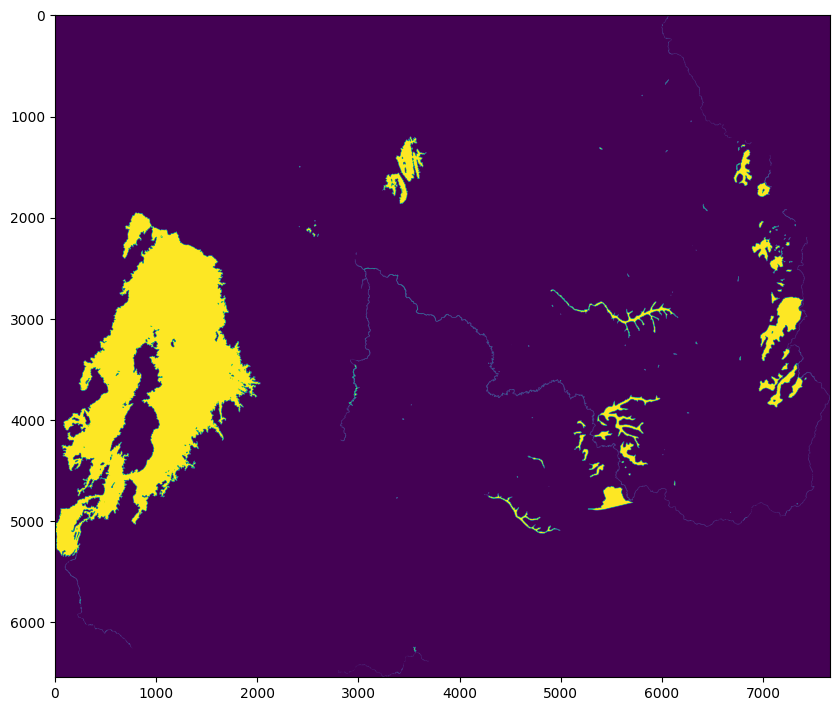

In [ ]:
from rasterio import features
from rasterio.plot import show
import matplotlib.pyplot as plt

# Read in vector
vector = gpd.read_file('/content/gdrive/MyDrive/Flood_Forecasting/data/Water/Aquatic_Border_Clip.shp')

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

# Open example raster
raster = rasterio.open(r"/content/gdrive/MyDrive/Flood_Forecasting/sentinel.tif")
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

with rasterio.open(
        "/content/gdrive/MyDrive/Flood_Forecasting/rasterized_waterBodies.tif", "w",
        driver = "GTiff",
        crs = raster.crs,
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax);

### Masking a both images using Rwanda boundaries shapefile

In [ ]:
with fiona.open("/content/gdrive/MyDrive/Flood_Forecasting/data/rwa_boundaries/rwa_administrative_boundaries_level_0.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    print(shapefile.crs)

EPSG:4326


In [ ]:
from rasterio.mask import mask

with rasterio.open( "/content/gdrive/MyDrive/Flood_Forecasting/rasterized_waterBodies.tif") as src:
    rasterizedMasked, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

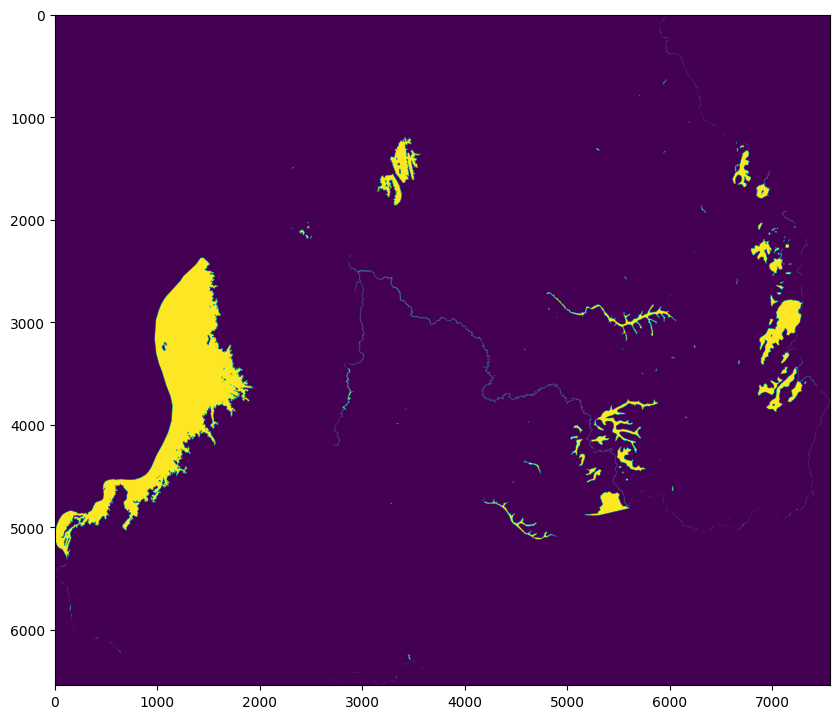

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterizedMasked, ax = ax);

In [ ]:
from rasterio.mask import mask

with rasterio.open( "/content/gdrive/MyDrive/Flood_Forecasting/sentinel.tif") as src:
    water, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    water[water !=1 ]=0
    out_meta = src.meta

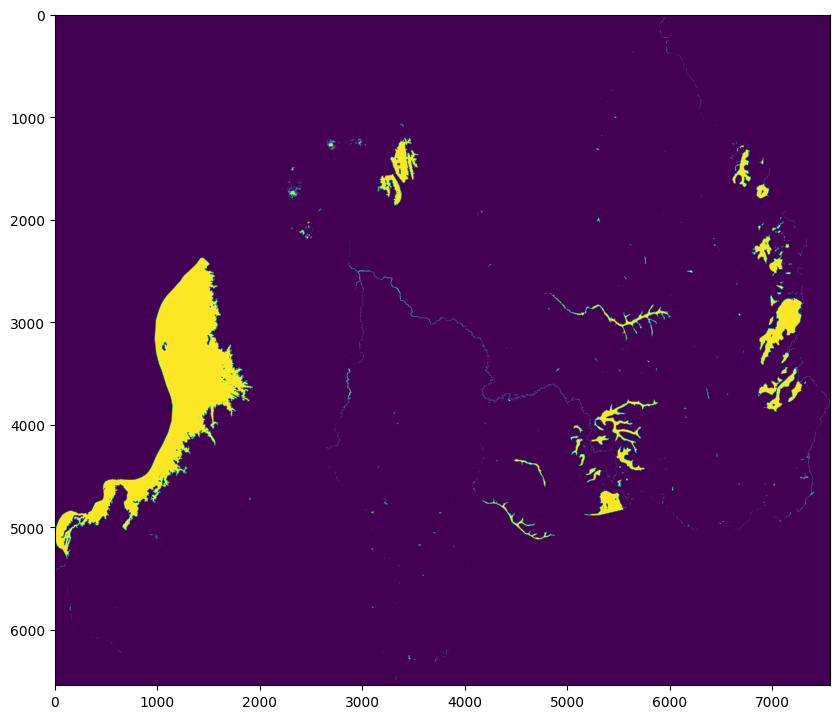

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 10))
ax.imshow(water.transpose(1,2,0))

In [ ]:
rasterizedMasked.shape, water.shape

((1, 6543, 7560), (1, 6543, 7560))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
ground_truth = rasterizedMasked.flatten()
predicted= water.flatten()

    # Calculate Pixel Accuracy
accuracy = accuracy_score(ground_truth, predicted)*100
print("Accuracy: ", accuracy)

f1 = f1_score(ground_truth, predicted)*100
print("F1: ", f1)

# Calculate Intersection over Union (IoU)
# intersection = np.logical_and(predicted, ground_truth)
# union = np.logical_or(predicted, ground_truth)
# iou = np.sum(intersection) / np.sum(union)
# print("IoU: ",iou*100)

Accuracy:  99.7887600707408
F1:  97.04629088875862


#### Correlation with surface water

In [ ]:
print('Correlation coef: ', np.corrcoef(ground_truth, predicted)[0][1] * 100)

Correlation coef:  96.9367743764472


## Nana Oye

In [ ]:
!pip  install PyCRS geedim python-geohash

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.7 MB/s eta 0:00:00
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=e8ede4f84d2e5a7de2fe90bcde36daf4594401cc64720e31488e38aa1a34fe56
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
  Created wheel for python-geohash: filename=python_geohash-0.8.5-cp310-cp310-linux_x86_64.whl size=41539 sha256=3ec433f2ae70945f7e882a532e135ed611d040c42ad9abdb212715f55598c50c
  Stored in directory: /root/.cache/pip/wheels/19/e8/74/3f800ffdbb57c27a3fee3a695c7009769356448837c1f4f899
Successfully built PyCRS python-geohash


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-mbwirayesugustave")

In [ ]:
import geemap
import geopandas as gpd
# import geohash
from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:

#Loading shapefile from DE Africa using geopandas
shapefile_path = "gdrive/MyDrive/Nana_Oye/Water Bodies/waterbodies.shp" # 'gdrive/MyDrive/Colab Notebooks/Water Bodies/waterbodies.shp'
water_bodies_gdf = gpd.read_file(shapefile_path)

In [ ]:
geojson_dict = water_bodies_gdf.__geo_interface__

In [ ]:
water_bodies_gdf

,area_m2,UID,WB_ID,perim_m,timeseries,geometry
0,11700.0000,e9pvzx5t2,0,780.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((-11.26792 6.67557, -11.26668 6.67557..."
1,147599.9999,e9pvzxcs1,1,4260.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((-11.26730 6.68314, -11.26668 6.68314..."
2,6300.0000,e9pvzzx9v,2,360.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((-11.25113 6.67746, -11.24989 6.67746..."
3,11700.0000,e9pxxzp4y,3,720.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((-11.60341 6.98316, -11.60310 6.98316..."
4,44100.0000,e9pxzb5ze,4,1680.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((-11.60776 6.99074, -11.60745 6.99074..."
...,...,...,...,...,...,...
688491,31500.0000,t4jtr87cd,688491,1080.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((53.06775 12.17501, 53.07055 12.17501..."
688492,36000.0000,t4jv01978,688492,1860.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((53.08796 12.14087, 53.08827 12.14087..."
688493,10800.0000,t4jv046nu,688493,540.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((53.08858 12.14328, 53.08889 12.14328..."
688494,63000.0000,t4jv05973,688494,2100.0,https://deafrica-services.s3.af-south-1.amazon...,"POLYGON ((53.08796 12.15145, 53.08827 12.15145..."


Each water body polygon’s unique identifier (UID) is a geohash, which represents the lat/lon coordinates of the centre of the water body polygon mapped into a shorter character string. `geohash` library can be used to convert bact to lat/lon

In [ ]:
# geohash.decode(water_bodies_gdf.iloc[0]['UID']) # Convertinggeohash back to lat/lon pain

<Axes: >

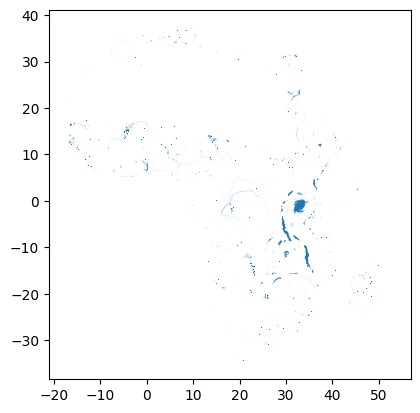

In [ ]:
water_bodies_gdf.plot()

In [ ]:
def defineROI(geojson_dict, Id):
    area = None
    for feature in geojson_dict['features']:
        if feature['properties']['UID'] == Id:
            area = ee.Geometry(feature['geometry'])
    return area

In [ ]:
def loadImgCollection(start_date, end_date, roi):
    collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
    .filterDate(start_date, end_date) \
    .filterBounds(roi))
    return collection

In [ ]:
def find_water_body(water_bodies, point):
    for index, row in water_bodies.iterrows():
        if row['geometry'].contains(point):
            return row.UID
    return None

In [ ]:
def maskCloudLandsat(image):
    # Bits 3 and 4 are cloud and cloud shadow, respectively.
    cloudsBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    qa = image.select('QA_PIXEL')

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
        .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

    # Return the masked image, scaled to reflectance, without the QA bands.
    return image.updateMask(mask)\
        .copyProperties(image, ['system:time_start'])


In [ ]:
def interpolateWithFocalMean(image):
    interpolated = image.unmask().focal_mean(radius=30, units='meters', kernelType='circle', iterations=3)
    return image.unmask(interpolated)

In [ ]:
# Mosaic images by date in case ROI covers more than one tile.
def mosaic_by_date_and_clip(date, collection,roi):
    date = ee.Date(date)
    daily_images = collection.filterDate(date, date.advance(1, 'day'))
    return daily_images.mosaic().clip(roi).set('system:time_start', date)

### Sibayi lake

In [ ]:
# Center (latitude and longitude) of Sibayi Lake. Replace with centoid lon/lat of your Region of Interest
lat = -27.3800
lon = 32.6900

# Create a Point object from the provided coordinates
point = Point(lon, lat)

# Find the water body's UID
matching_region = find_water_body(water_bodies_gdf, point)

In [ ]:

if matching_region is not None:
    print(f"Matching region's UID: {matching_region}")
else:
    print("No matching region found.")

Matching region's UID: kephrmphc


In [ ]:
start_date, end_date = '2021-01-01', '2023-12-31' # Time of interest

roi = defineROI(geojson_dict, matching_region)
img_collection = loadImgCollection(start_date, end_date, roi) # Landsat image collection

In [ ]:
# Group images by date.
dates = img_collection.aggregate_array('system:time_start').distinct().getInfo()
mosaicked_images = [mosaic_by_date_and_clip(date, img_collection, roi) for date in dates]

# Create an ImageCollection from the mosaicked images.
mosaicked_collection = ee.ImageCollection(mosaicked_images)

# Uncomment the following line to mask clouds and interpolate the gaps using focal mean
# mosaicked_collection = mosaicked_collection.map(maskCloudLandsat).map(interpolateWithFocalMean)

#### Visualization

In [ ]:
Map = geemap.Map()

In [ ]:
# Center the map at roi centroid.
center = ee.Geometry.Point(roi.centroid(10).coordinates().getInfo())
Map.centerObject(center, 12)

# Add layer to the map
Map.addLayer(roi, {}, 'Region of Interest')
Map.addLayer(mosaicked_collection.first().multiply(0.0000275).add(-0.2), {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, 'first')

In [ ]:
Map

Map(center=[-27.349640189917565, 32.672023204646386], controls=(WidgetControl(options=['position', 'transparen…

#### Download data

In [ ]:
# geemap.ee_export_image_collection(mosaicked_collection, out_dir='/content/gdrive/MyDrive/Nana_Oye', scale=30, region=roi, file_per_band=False)